### This notebook is for evaluating the model

Installing the required libraries

In [ ]:
%pip install yfinance
%pip install XGBoost
%pip install scikit-learn
%pip install matplotlib

: 

Feature engineering and creating the model

In [2]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def create_lag_features(df, lags=[1, 2, 3, 5, 7, 14, 30]):
    for lag in lags:
        df[f'lag_{lag}'] = df['price'].shift(lag)
    df['rolling_7_mean'] = df['price'].rolling(window=7).mean()
    df['rolling_30_mean'] = df['price'].rolling(window=30).mean()
    return df.dropna()

def xgboost_model(df, metal_name, test_size=0.2, random_state=42):
    X = df.drop(['date', 'price'], axis=1)
    y = df['price']

    tscv = TimeSeriesSplit(n_splits=5, test_size=30)

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        enable_categorical=True,
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=50,
        random_state=random_state
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    y_pred = model.predict(X_test)

    print(f"{metal_name} Model RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

    xgb.plot_importance(model, max_num_features=10)
    plt.title(f'{metal_name} Feature Importance')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, y_pred, label='Predicted')
    plt.title(f'{metal_name} Price: Actual vs Predicted')
    plt.legend()
    plt.show()

    return model


Matplotlib is building the font cache; this may take a moment.


Testing the model with the gold data

/var/folders/hc/3rz1mft97xvcb7nx0wxv3gh00000gn/T/ipykernel_41566/1001080510.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('GC=F', '2013-01-01')
[*********************100%***********************]  1 of 1 completed

[0]	validation_0-rmse:470.59178	validation_1-rmse:1716.06239
[100]	validation_0-rmse:176.09477	validation_1-rmse:677.03307


[200]	validation_0-rmse:67.41317	validation_1-rmse:276.87782
[300]	validation_0-rmse:28.95095	validation_1-rmse:120.57140
[400]	validation_0-rmse:16.98981	validation_1-rmse:63.51436
[500]	validation_0-rmse:13.66264	validation_1-rmse:43.49173
[600]	validation_0-rmse:12.55527	validation_1-rmse:35.57101
[700]	validation_0-rmse:11.98531	validation_1-rmse:33.32288
[800]	validation_0-rmse:11.59312	validation_1-rmse:32.66025
[859]	validation_0-rmse:11.40903	validation_1-rmse:32.74406
gold Model RMSE: 32.60


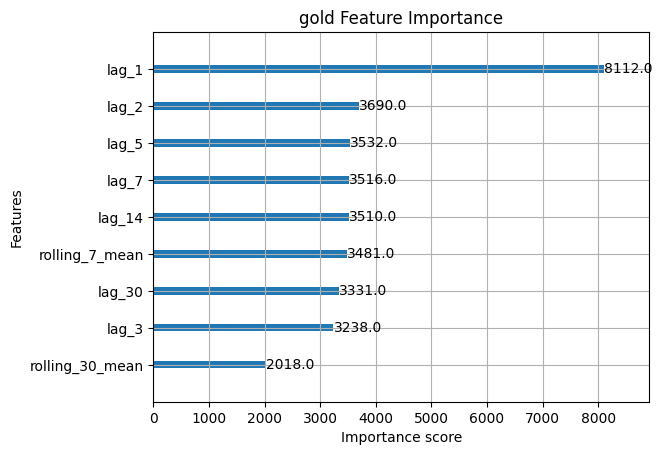

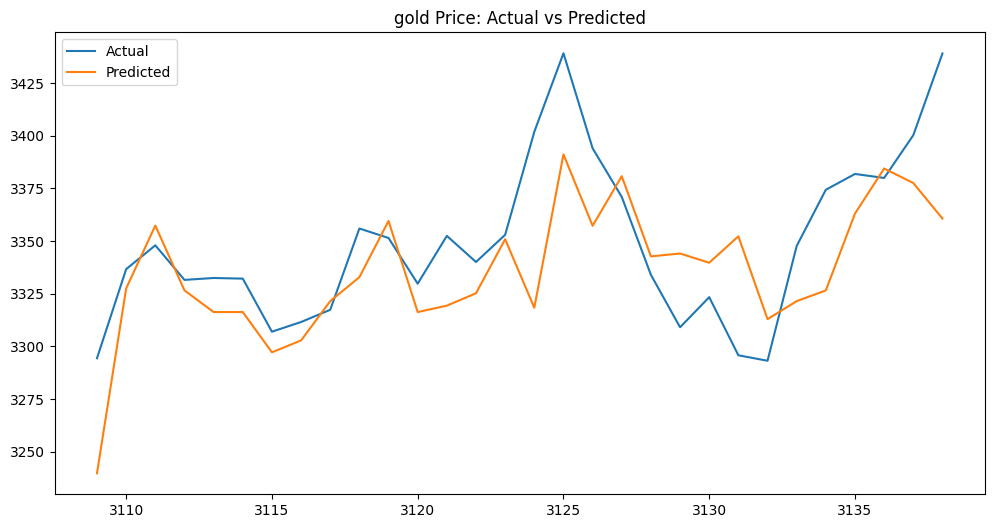

In [ ]:
import yfinance as yf

data = yf.download('GC=F', '2013-01-01')
data.columns = data.columns.get_level_values(0)
data = data['Close']
data = data.reset_index(drop=False)
data.columns = ['date', 'price']
data = create_lag_features(data)
data = data.reset_index(drop=True)

model = xgboost_model(data, 'gold')